# Imports and definitions

In [1]:
from XRDXRFutils.notebook_utils import *


### Size of the detector ###
n_channels = 1280
length_channel = 50 * 10**(-4)   # in cm
width_channel = 999
L = n_channels * length_channel   # length of the detector


### Output ###
path_figures = 'figures/'
paths_to_create_delete = [path_figures]


### Utility functions ###
def distance(A, B):
    return sqrt(power(A[0] - B[0], 2) + power(A[1] - B[1], 2))

def weighted_std(values, axis = None, weights = None):
    avg = average(values, axis = axis, weights = weights, keepdims = True)
    var = average((values - avg)**2, axis = axis, weights = weights)
    return sqrt(var)

def a_s_from_beta(beta, L, theta_min, theta_max):
    factor = L * cos(deg2rad(theta_max - beta)) / sin(deg2rad(theta_max - theta_min))
    a = factor * sin(deg2rad(theta_min - beta))
    s = factor * cos(deg2rad(theta_min - beta))
    return a, s


def distance_to_angle(x, a, s, beta):
    return rad2deg(arctan((x + a) / s)) + beta

def channel_to_angle(c, a, s, beta):
    x = c * length_channel
    return distance_to_angle(x, a, s, beta)

def angle_to_distance(theta, a, s, beta):
    return s * tan(deg2rad(theta - beta)) - a

def angle_to_channel(theta, a, s, beta):
    x = angle_to_distance(theta, a, s, beta)
    return x / length_channel


def defocus(theta, s, beta, i, d, omega):
    Delta_f = (1 / cos(deg2rad(theta - beta))) * s - (sin(deg2rad(theta - i)) / sin(deg2rad(i))) * d
    Delta_p = (sin(deg2rad(omega)) / cos(deg2rad(theta - beta + omega))) * Delta_f
    Delta_theta = rad2deg(arctan(tan(deg2rad(theta - beta)) + Delta_p / s)) - (theta - beta)
    return Delta_f, Delta_p, Delta_theta

def plot_experimental_setting(L, a, s, beta, i, d, omega, theta, ax, legend = False, secondary_ray = True):
    # Calculations
    coords_S = [-d * cos(deg2rad(i)), d * sin(deg2rad(i))]
    coords_O = [0, 0]
    coords_O1 = [(sin(deg2rad(omega)) * cos(deg2rad(omega)) / sin(deg2rad(i))) * d, (power(sin(deg2rad(omega)), 2) / sin(deg2rad(i))) * d]
    coords_F = [d * sin(deg2rad(theta - i)) * cos(deg2rad(theta - i)) / sin(deg2rad(i)), d * power(sin(deg2rad(theta - i)), 2) / sin(deg2rad(i))]
    coords_A = [s * cos(deg2rad(beta - i)) - a * sin(deg2rad(beta - i)), a * cos(deg2rad(beta - i)) + s * sin(deg2rad(beta - i))]
    coords_B = [s * cos(deg2rad(beta - i)) - (L + a) * sin(deg2rad(beta - i)), (L + a) * cos(deg2rad(beta - i)) + s * sin(deg2rad(beta - i))]
    coords_Q = [s * cos(deg2rad(beta - i)), s * sin(deg2rad(beta - i))]
    coords_P = [s * cos(deg2rad(theta - i)) / cos(deg2rad(theta - beta)), s * sin(deg2rad(theta - i)) / cos(deg2rad(theta - beta))]
    coords_P1 = [
        ( 1 / cos(deg2rad(theta + omega - beta)) ) * ( (sin(deg2rad(beta - i)) * sin(deg2rad(omega)) * sin(deg2rad(theta - i)) / sin(deg2rad(i))) * d + cos(deg2rad(theta - i + omega)) * s ),
        ( 1 / cos(deg2rad(theta + omega - beta)) ) * ( sin(deg2rad(theta - i + omega)) * s - ( cos(deg2rad(beta - i)) * sin(deg2rad(omega)) * sin(deg2rad(theta - i)) / sin(deg2rad(i)) ) * d )
    ]
    Delta_f, Delta_p, Delta_theta = defocus(theta, s, beta, i, d, omega)

    ### Figure
    ax.set_aspect(1)

    # Draw the circle
    radius = d / (2 * sin(deg2rad(i)))
    circle_focus = Circle((0, radius), radius, fill = False, color = 'black', lw = 1, ls = '--')
    ax.add_artist(circle_focus)

    # Draw the detector
    ax.plot([coords_A[0], coords_B[0]], [coords_A[1], coords_B[1]], color = 'black', lw = 2)
    ax.plot([coords_O[0], coords_Q[0]], [coords_O[1], coords_Q[1]], color = 'black', lw = 1, ls = '--')
    if ((a > 0) or (a < -L)):
        ax.plot([coords_A[0], coords_Q[0]], [coords_A[1], coords_Q[1]], color = 'black', lw = 1, ls = '--')

    # Draw the rays
    ax.plot([coords_S[0], coords_O[0]], [coords_S[1], coords_O[1]], color = 'tab:blue', lw = 1.5, label = 'central ray')
    ax.plot([coords_O[0], coords_F[0]], [coords_O[1], coords_F[1]], color = 'tab:blue', lw = 1.5)
    ax.plot([coords_P[0], coords_F[0]], [coords_P[1], coords_F[1]], color = 'tab:blue', lw = 1.5)
    if secondary_ray:
        ax.plot([coords_S[0], coords_O1[0]], [coords_S[1], coords_O1[1]], color = 'tab:orange', lw = 1.5, label = 'secondary ray')
        ax.plot([coords_O1[0], coords_F[0]], [coords_O1[1], coords_F[1]], color = 'tab:orange', lw = 1.5)
        ax.plot([coords_P1[0], coords_F[0]], [coords_P1[1], coords_F[1]], color = 'tab:orange', lw = 1.5)

    # Mark the points
    list_coords = [coords_S, coords_O, coords_F, coords_A, coords_B, coords_P]
    list_letters = ['S', 'O', 'F', 'A', 'B', 'P']
    if secondary_ray:
        list_coords += [coords_O1, coords_P1]
        list_letters += ['O\'', 'P\'']
    for coords, letter in zip(list_coords, list_letters):
        ax.scatter(*coords, c = 'black', s = 20, zorder = 2.5)
        ax.annotate(letter, coords, ha = 'left', va = 'bottom')

    ax.set_xlabel(r'$x$ (cm)')
    ax.set_ylabel(r'$y$ (cm)')
    ax.set_title('System setup')
    if legend:
        ax.legend(frameon = True, bbox_to_anchor = (1, 1), loc = 'upper left')
    return Delta_f, Delta_p, Delta_theta

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False
if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Positioning detector with fixed $\theta_\textrm{min}$ and $\theta_\textrm{max}$

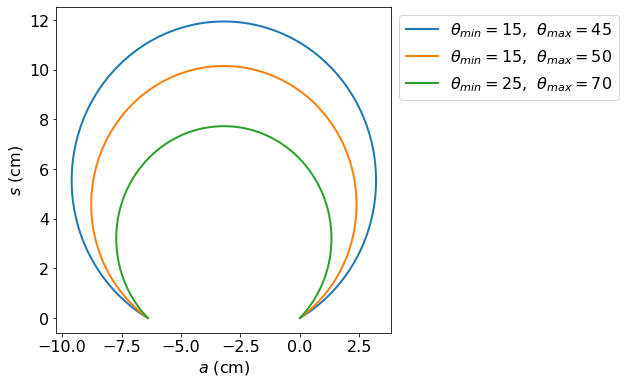

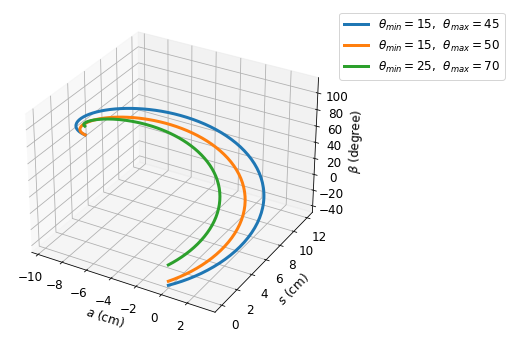

In [4]:
theta_min_choices = [15, 15, 25]
theta_max_choices = [45, 50, 70]

###

list_a, list_s, list_beta = [], [], []
for theta_min, theta_max in zip(theta_min_choices, theta_max_choices):
    beta = arange(theta_max - 90, theta_min + 90.1, 1)
    a, s = a_s_from_beta(beta, L, theta_min, theta_max)
    list_a.append(a)
    list_s.append(s)
    list_beta.append(beta)

rcParams['font.size'] = 16

fig, ax = subplots(figsize = (6, 6))
for i in range(len(list_beta)):
    ax.plot(list_a[i], list_s[i], ls = '-', lw = 2, label = r'$\theta_{min} = $' + f'{theta_min_choices[i]}' + r',  $\theta_{max} = $' + f'{theta_max_choices[i]}')
ax.set_xlabel(r'$a$ (cm)')
ax.set_ylabel(r'$s$ (cm)')
ax.legend(frameon = True, bbox_to_anchor = (1, 1), loc = 'upper left')
savefig(f'{path_figures}circle_2d.png', bbox_inches = 'tight', dpi = 300)
show()

rcParams['font.size'] = 12

fig = figure(figsize = (6, 6))
ax = fig.add_subplot(projection = '3d')
for i in range(len(list_beta)):
    ax.plot(list_a[i], list_s[i], list_beta[i], lw = 3, label = r'$\theta_{min} = $' + f'{theta_min_choices[i]}' + r',  $\theta_{max} = $' + f'{theta_max_choices[i]}')
    #ax.scatter(list_a[i], list_s[i], list_beta[i], lw = 3, label = r'$\theta_{min} = $' + f'{theta_min_choices[i]}' + r',  $\theta_{max} = $' + f'{theta_max_choices[i]}')
ax.set_xlabel(r'$a$ (cm)')
ax.set_ylabel(r'$s$ (cm)')
ax.set_zlabel(r'$\beta$ (degree)')
ax.legend(frameon = True, bbox_to_anchor = (1, 1), loc = 'upper left')
savefig(f'{path_figures}circle_3d.png', bbox_inches = 'tight', dpi = 300)
show()

# Focus error

### Geometry of the system

In [15]:
### Geometry of the detector (Venere)
theta_min = 16.13
theta_max = 44.17
beta = 42.05   # Orientation of the detector

### Geometry of the detector (Oslo)
#theta_min = 19.78
#theta_max = 53.58
#beta = 51.66   # Orientation of the detector

In [34]:
### Geometry of the beam
i = 10   # Incident angle
d = 0.8 * L   # Distance between sample and focus of the source
omega = 3   # Deviation angle of the followed secondary ray
sigma_omega = 0.02   # Angular disperion of the beam

### Diffraction
#theta = (theta_min + theta_max) / 2
theta = 30

a, s = -5.947, 12.237
beta = 42.05
d/L = 0.800
d = 5.120 cm
i = 10
theta = 30


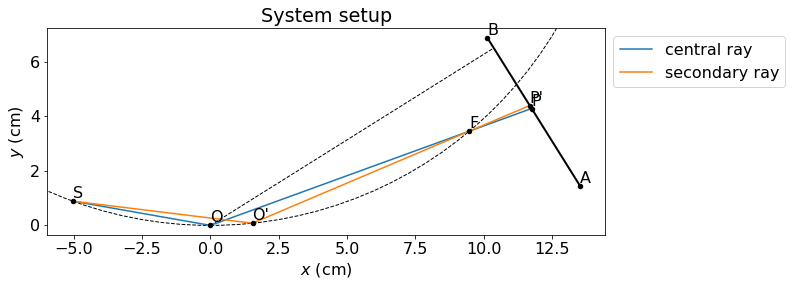

Df = 2.428 cm
Dp = 0.129 cm (25.733 channels)
Dtheta = 0.577


In [35]:
rcParams['font.size'] = 16
plot_secondary_ray = True

###

a, s = a_s_from_beta(beta, L, theta_min, theta_max)

print(f'a, s = {a:.3f}, {s:.3f}')
print(f'beta = {beta}')
print(f'd/L = {d/L:.3f}')
print(f'd = {d:.3f} cm')
print(f'i = {i}')
print(f'theta = {theta}')

### Figure
fig, ax = subplots(figsize = (10, 10))
Delta_f, Delta_p, Delta_theta = plot_experimental_setting(L, a, s, beta, i, d, omega, theta, ax, legend = True, secondary_ray = plot_secondary_ray)
show()

print(f'Df = {Delta_f:.3f} cm')
print(f'Dp = {Delta_p:.3f} cm ({Delta_p / length_channel:.3f} channels)')
print(f'Dtheta = {Delta_theta:.3f}')

show()

### Convert coordinates

In [ ]:
R = sqrt(power(s, 2))

### Geometry and defocus in the detector for varying $d/L$

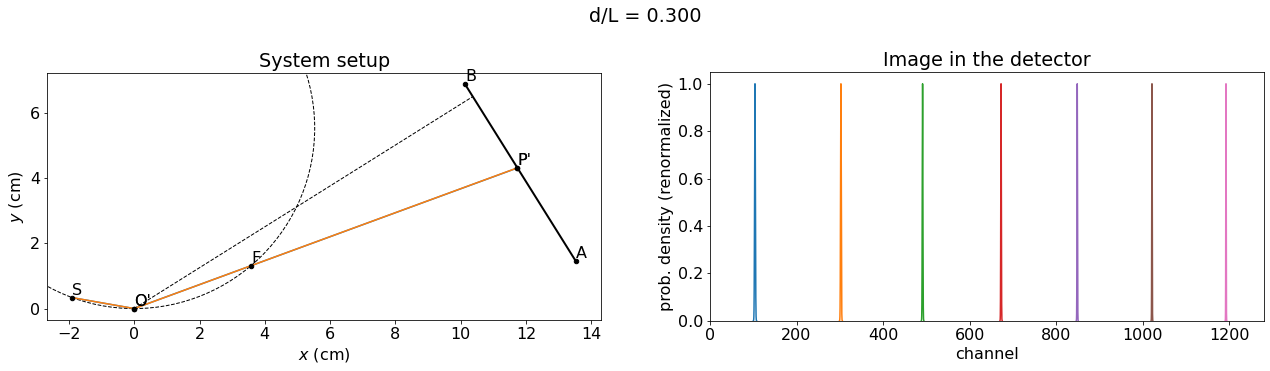

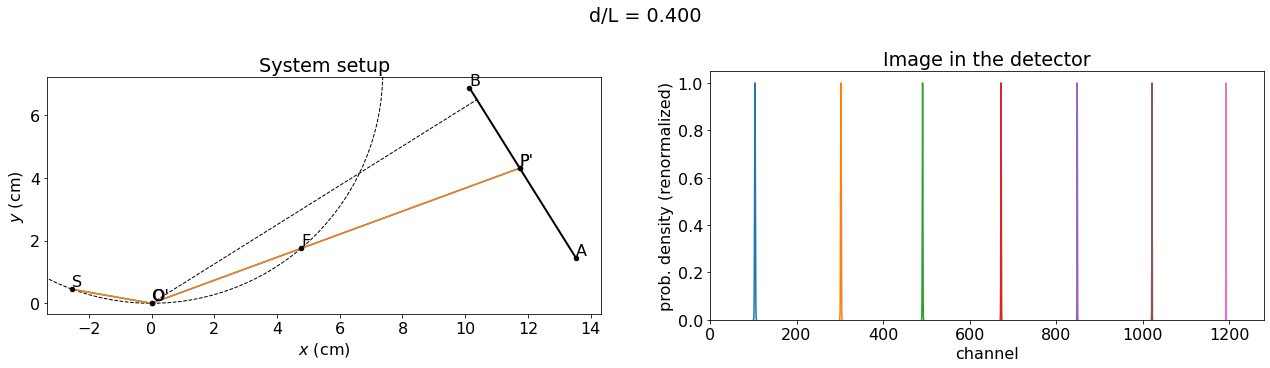

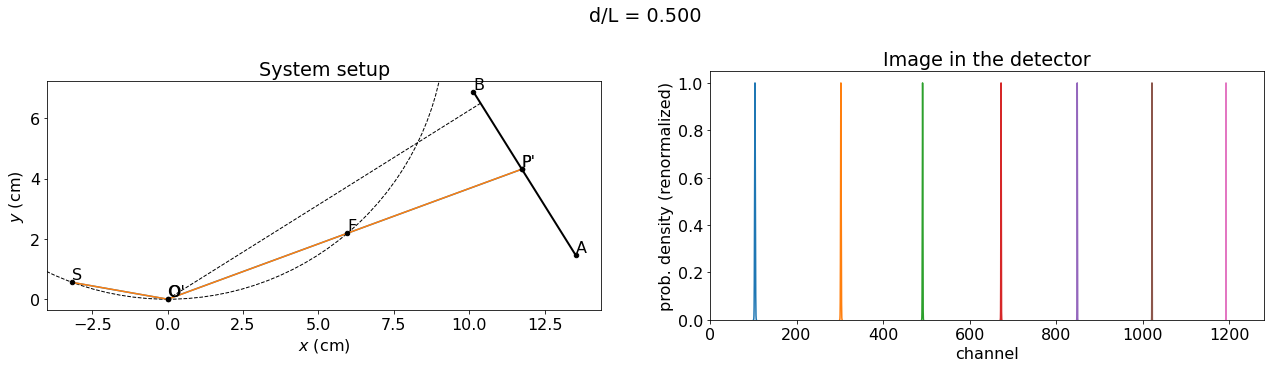

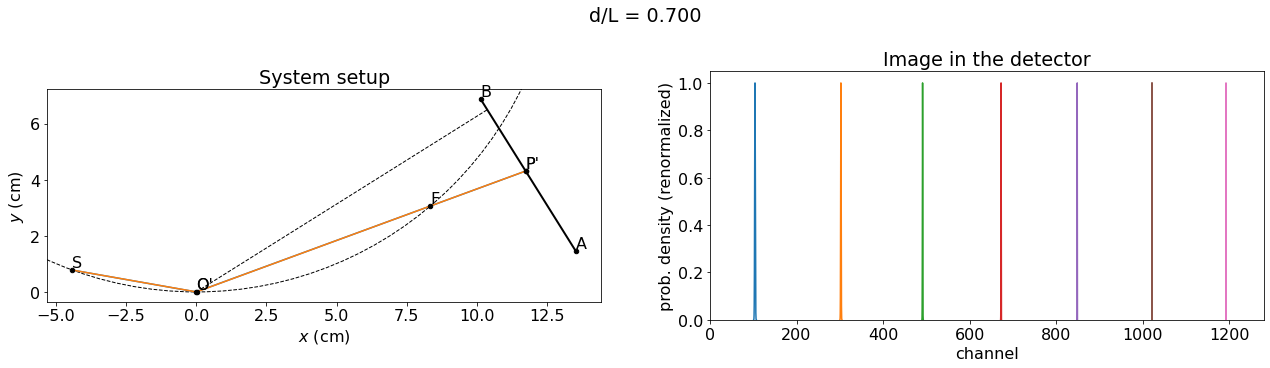

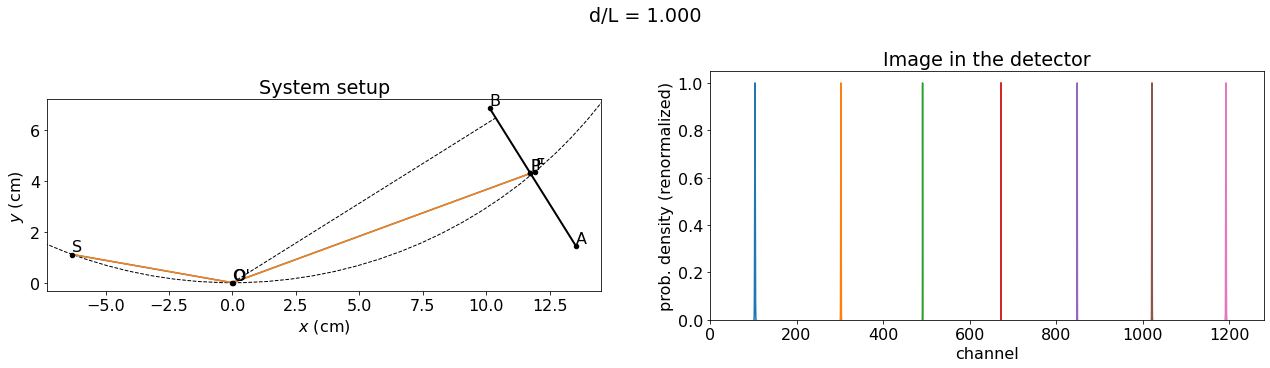

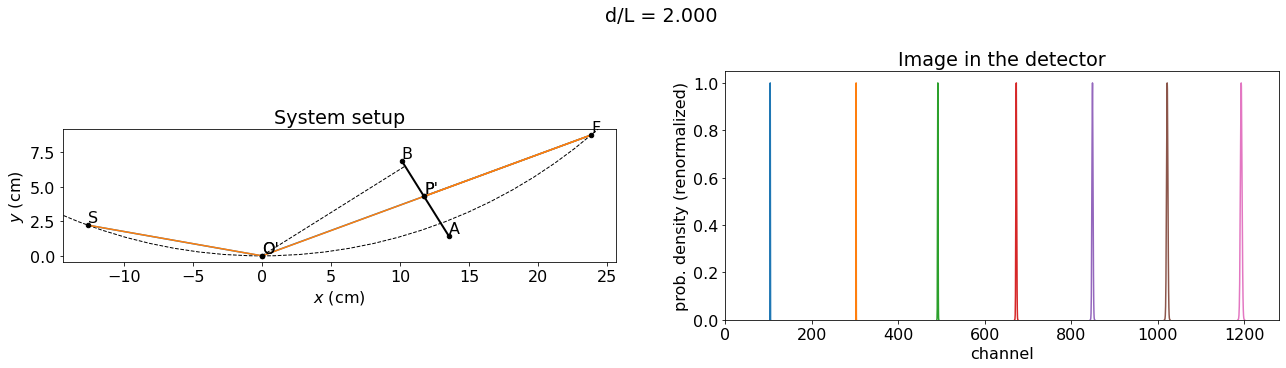

In [36]:
# Plot
rcParams['font.size'] = 16
plot_theta = False   # If true, plot diffraction peaks in theta; otherwise, plot them in channels

list_d = [0.3 * L, 0.4 * L, 0.5 * L, 0.7 * L, 1 * L, 2 * L]   # Distance between detector and focus of the source


###


# Fixed: L, theta_min, theta_max, i, sigma_omega
# Varying: beta (--> a, s), d, theta (--> channel), omega
# Focus errors depending on multiple dimensions: beta, d/L, theta, omega

# Orientation of the detector
arr_beta = expand_dims(array([beta]), axis = [1, 2, 3])
#arr_beta = expand_dims(arange(theta_min, theta_max + 1), axis = [1, 2, 3])
arr_a, arr_s = a_s_from_beta(arr_beta, L, theta_min, theta_max)

# Distance of the source
arr_d = expand_dims(array(list_d), axis = [0, 2, 3])

# Channels and angles in the detector
#arr_channel = expand_dims(arange(0, n_channels, 5), axis = [0, 1, 3])
#arr_theta = channel_to_angle(arr_channel, arr_a, arr_s, arr_beta)
arr_theta = expand_dims(arange(theta_min + 2, theta_max, 4), axis = [0, 1, 3])
arr_channel = angle_to_channel(arr_theta, arr_a, arr_s, arr_beta)

# Distribution of rays
arr_omega = expand_dims(linspace(- 4 * sigma_omega, 4 * sigma_omega, 500), axis = [0, 1, 2])
arr_gaussian = squeeze( exp(- power(arr_omega, 2) / (2 * power(sigma_omega, 2))) )

# Calculation of errors
Delta_f, Delta_p, Delta_theta = defocus(arr_theta, arr_s, arr_beta, i, arr_d, arr_omega)
arr_channels_disp = arr_channel + (Delta_p / length_channel)
arr_theta_disp = arr_theta + Delta_theta

#print(f'arr_beta: {arr_beta.shape}')
#print(f'arr_a: {arr_a.shape}')
#print(f'arr_d: {arr_d.shape}')
#print(f'arr_channel: {arr_channel.shape}')
#print(f'arr_theta: {arr_theta.shape}')
#print(f'arr_omega: {arr_omega.shape}')
#print(f'arr_gaussian: {arr_gaussian.shape}')
#print(f'Delta_theta: {Delta_theta.shape}')
#print(f'arr_theta_disp: {arr_theta_disp.shape}')


###


idx_beta = 0
beta_plot = arr_beta.flatten()[idx_beta]
a = arr_a.flatten()[idx_beta]
s = arr_s.flatten()[idx_beta]

for idx_d, d in enumerate(arr_d.flatten()):
    fig, axs = subplots(1, 2, figsize = (18, 5))
    fig.tight_layout(w_pad = 4)
    fig.subplots_adjust(top = 0.8)   # To shift the title
    
    ax = axs[0]
    theta = (theta_min + theta_max) / 2
    omega = sigma_omega
    plot_experimental_setting(L, a, s, beta_plot, i, d, omega, theta, ax, legend = False)
    
    ax = axs[1]
    if plot_theta:
        for idx_theta, theta in enumerate(arr_theta.flatten()):
            ax.plot(arr_theta_disp[0, idx_d, idx_theta, :], arr_gaussian)
        ax.set_xlim(theta_min, theta_max)
        ax.set_ylim(0, None)
        ax.set_xlabel(r'angle $2 \theta$ (degree)')
        ax.set_ylabel('prob. density (renormalized)')
        ax.set_title('Image in the detector')
    else:
        for idx_theta, theta in enumerate(arr_theta.flatten()):
            ax.plot(arr_channels_disp[idx_beta, idx_d, idx_theta, :], arr_gaussian)
        ax.set_xlim(0, n_channels)
        ax.set_ylim(0, None)
        ax.set_xlabel('channel')
        ax.set_ylabel('prob. density (renormalized)')
        ax.set_title('Image in the detector')

    fig.suptitle(f'd/L = {d/L:.3f}')
    show()

### Angular error for varying $d/L$

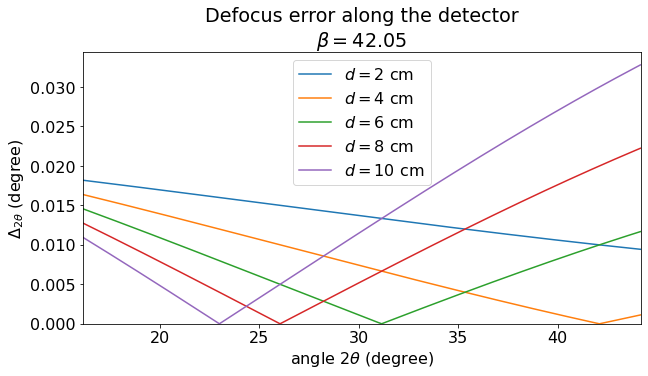

In [37]:
rcParams['font.size'] = 16

#list_d = [0.2 * L, 0.6 * L, 1.0 * L, 1.5 * L, 2 * L]   # Distance between detector and focus of the source
list_d = list(range(2, 11, 2))   # Distance between detector and focus of the source


###


arr_beta = expand_dims(array([beta]), axis = [1, 2, 3])
arr_a, arr_s = a_s_from_beta(arr_beta, L, theta_min, theta_max)
arr_d = expand_dims(array(list_d), axis = [0, 2, 3])
arr_channel = expand_dims(arange(0, n_channels, 1), axis = [0, 1, 3])
arr_theta = channel_to_angle(arr_channel, arr_a, arr_s, arr_beta)
arr_omega = expand_dims([-sigma_omega, sigma_omega], axis = [0, 1, 2])
Delta_f, Delta_p, Delta_theta = defocus(arr_theta, arr_s, arr_beta, i, arr_d, arr_omega)

arr_std = average(absolute(Delta_theta), axis = 3)

fig, ax = subplots(figsize = (10, 5))
for idx_d, d_plot in enumerate(arr_d.flatten()):
    #ax.plot(arr_theta.flatten(), arr_std[0, idx_d, :], label = r'$d/L = $' + f'{d_plot/L:.2f}')
    ax.plot(arr_theta.flatten(), arr_std[0, idx_d, :], label = r'$d = $' + f'{d_plot} cm')
ax.legend(frameon = True)
ax.set_xlim(theta_min, theta_max)
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2 \theta$ (degree)')
ax.set_ylabel(r'$\Delta_{2\theta}$ (degree)')
ax.set_title('Defocus error along the detector\n' + r'$\beta = $' + f'{beta}')
show()

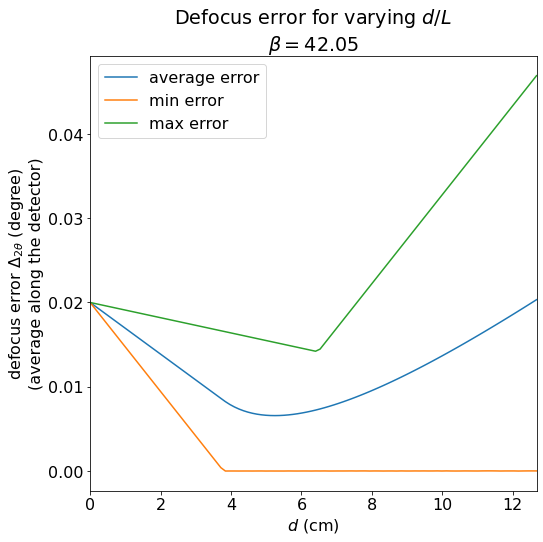

In [38]:
rcParams['font.size'] = 16

d_L_min, d_L_max, d_L_step = 0, 2, 0.02   # d/L (distance of the focus of the source / length of the detector)

###

arr_beta = expand_dims(array([beta]), axis = [1, 2, 3])
arr_a, arr_s = a_s_from_beta(arr_beta, L, theta_min, theta_max)
arr_d = expand_dims(arange(d_L_min, d_L_max, d_L_step) * L, axis = [0, 2, 3])
arr_channel = expand_dims(arange(0, n_channels, 1), axis = [0, 1, 3])
arr_theta = channel_to_angle(arr_channel, arr_a, arr_s, arr_beta)
arr_omega = expand_dims([-sigma_omega, sigma_omega], axis = [0, 1, 2])
Delta_f, Delta_p, Delta_theta = defocus(arr_theta, arr_s, arr_beta, i, arr_d, arr_omega)

arr_error_avg = absolute(Delta_theta).mean(axis = (2, 3))[idx_beta]
arr_error_min = absolute(Delta_theta).mean(axis = 3).min(axis = 2)[idx_beta]
arr_error_max = absolute(Delta_theta).mean(axis = 3).max(axis = 2)[idx_beta]

fig, ax = subplots(figsize = (8, 8))
ax.plot(arr_d.flatten(), arr_error_avg, label = 'average error')
ax.plot(arr_d.flatten(), arr_error_min, label = 'min error')
ax.plot(arr_d.flatten(), arr_error_max, label = 'max error')
ax.legend(frameon = True)
ax.set_xlim(arr_d.flatten()[[0, -1]])
ax.set_xlabel(r'$d$ (cm)')
ax.set_ylabel('defocus error ' + r'$\Delta_{2\theta}$ (degree)' + '\n(average along the detector)')
ax.set_title(r'Defocus error for varying $d/L$' + '\n' + r'$\beta = $' + f'{arr_beta.flatten()[idx_beta]}')
show()

### Angular error for varying $\beta$

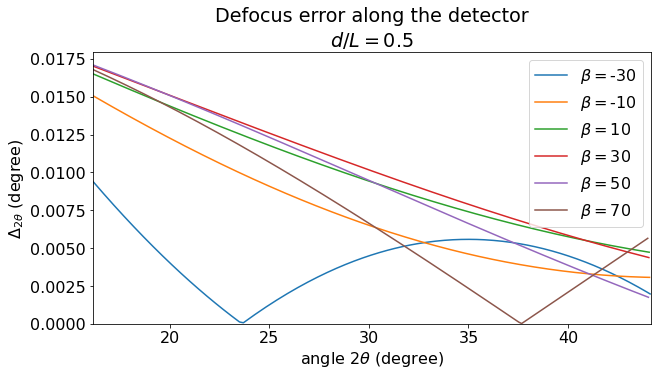

In [39]:
rcParams['font.size'] = 16

d = 0.5 * L   # Distance between detector and focus of the source
list_beta = list(range(-30, 90, 20))   # Orientation of the detector
#list_beta = [10.01, 42]
sigma_omega = 0.02   # Angular disperion of the beam


###


arr_beta = expand_dims(array(list_beta), axis = [1, 2, 3])
arr_a, arr_s = a_s_from_beta(arr_beta, L, theta_min, theta_max)
arr_d = expand_dims(array([d]), axis = [0, 2, 3])
arr_channel = expand_dims(arange(0, n_channels, 5), axis = [0, 1, 3])
arr_theta = channel_to_angle(arr_channel, arr_a, arr_s, arr_beta)
arr_omega = expand_dims([-sigma_omega, sigma_omega], axis = [0, 1, 2])
Delta_f, Delta_p, Delta_theta = defocus(arr_theta, arr_s, arr_beta, i, arr_d, arr_omega)

arr_std = average(absolute(Delta_theta), axis = 3)

fig, ax = subplots(figsize = (10, 5))
for idx_beta, beta_plot in enumerate(arr_beta.flatten()):
    ax.plot(arr_theta[idx_beta].flatten(), arr_std[idx_beta, 0, :], label = r'$\beta = $' + f'{beta_plot}')
ax.legend(frameon = True)
ax.set_xlim(theta_min, theta_max)
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2 \theta$ (degree)')
ax.set_ylabel(r'$\Delta_{2\theta}$ (degree)')
ax.set_title('Defocus error along the detector\n' + r'$d/L = $' + f'{d/L}')
show()

### Colour map

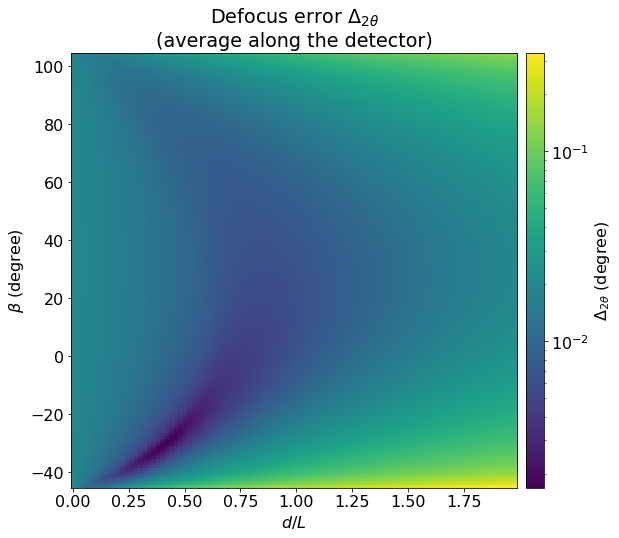

In [40]:
rcParams['font.size'] = 16

#beta_min, beta_max, beta_step = -40, 90, 1   # Orientation of the detector
beta_min, beta_max, beta_step = theta_max - 89, theta_min + 89, 1
d_L_min, d_L_max, d_L_step = 0, 2, 0.02   # d/L (distance of the focus of the source / length of the detector)
sigma_omega = 0.02   # Angular disperion of the beam

###

arr_beta = expand_dims(arange(beta_min, beta_max, beta_step), axis = [1, 2, 3])
arr_a, arr_s = a_s_from_beta(arr_beta, L, theta_min, theta_max)
arr_d = expand_dims(arange(d_L_min, d_L_max, d_L_step) * L, axis = [0, 2, 3])
arr_channel = expand_dims(arange(0, n_channels, 5), axis = [0, 1, 3])
arr_theta = channel_to_angle(arr_channel, arr_a, arr_s, arr_beta)
arr_omega = expand_dims([-sigma_omega, sigma_omega], axis = [0, 1, 2])
Delta_f, Delta_p, Delta_theta = defocus(arr_theta, arr_s, arr_beta, i, arr_d, arr_omega)

arr_std = average(absolute(Delta_theta), axis = (2, 3))

fig, ax = subplots(figsize = (8, 8))
im = ax.imshow(arr_std,
               norm = LogNorm(),
               extent = (d_L_min - d_L_step/2, d_L_max - d_L_step/2, beta_min - beta_step/2, beta_max - beta_step/2),
               aspect = 'auto', interpolation = 'none')
cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), label = r'$\Delta_{2\theta}$ (degree)')
cb.ax.yaxis.set_offset_position('left')
ax.set_xlabel(r'$d/L$')
ax.set_ylabel(r'$\beta$ (degree)')
ax.set_title('Defocus error ' + r'$\Delta_{2\theta}$' + '\n(average along the detector)')
show()

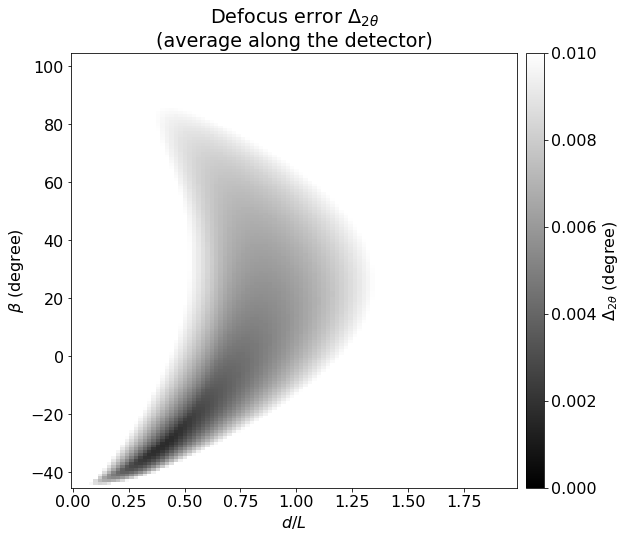

In [33]:
fig, ax = subplots(figsize = (8, 8))
im = ax.imshow(arr_std,
               extent = (d_L_min - d_L_step/2, d_L_max - d_L_step/2, beta_min - beta_step/2, beta_max - beta_step/2),
               aspect = 'auto', interpolation = 'none', cmap = 'gray',
               vmin = 0, vmax = 0.01)
cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), label = r'$\Delta_{2\theta}$ (degree)')
cb.ax.yaxis.set_offset_position('left')
ax.set_xlabel(r'$d/L$')
ax.set_ylabel(r'$\beta$ (degree)')
ax.set_title('Defocus error ' + r'$\Delta_{2\theta}$' + '\n(average along the detector)')
show()

In [40]:
arr_std.min()

0.0017015410304741518

In [41]:
arr_std.max()

0.5115049074010758